In [47]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [48]:
# Load NVIDIA stock data from Yahoo Finance
nvidia = yf.download('NVDA', start='2018-01-01', end='2024-01-01', interval='1d')
nvidia.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,48.945000,49.875000,48.625000,49.837502,49.310478,35561600
2018-01-03,51.025002,53.424999,50.937500,53.117500,52.555790,91470400
2018-01-04,53.939999,54.512501,53.172501,53.397499,52.832836,58326800
2018-01-05,53.547501,54.227501,52.770000,53.849998,53.280537,58012400
2018-01-08,55.099998,56.250000,54.645000,55.500000,54.913097,88121600


In [49]:
# Define technical indicator functions
def moving_average(df, window):
    return df['Close'].rolling(window=window).mean()

def exponential_moving_average(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def momentum(df, window):
    return df['Close'].diff(window)

def rsi(df, window):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Calculate technical indicators
nvidia['SMA10'] = moving_average(nvidia, 10)
nvidia['SMA60'] = moving_average(nvidia, 60)
nvidia['EMA10'] = exponential_moving_average(nvidia, 10)
nvidia['EMA20'] = exponential_moving_average(nvidia, 20)
nvidia['EMA50'] = exponential_moving_average(nvidia, 50)
nvidia['Momentum'] = momentum(nvidia, 10)
nvidia['RSI'] = rsi(nvidia, 14)

# Drop NaN values
nvidia.dropna(inplace=True)
nvidia.head()


,Open,High,Low,Close,Adj Close,Volume,SMA10,SMA60,EMA10,EMA20,EMA50,Momentum,RSI
Date,,,,,,,,,,,,,
2018-03-28,56.032501,57.347500,54.250000,55.337502,54.786327,94590400,60.128250,58.758333,59.216354,59.865011,58.796454,-6.847500,38.012335
2018-03-29,56.027500,58.875000,55.174999,57.897499,57.320854,91662800,59.684500,58.892667,58.976562,59.677628,58.761201,-4.437500,42.263505
2018-04-02,57.185001,58.662498,54.375000,55.262501,54.712078,92209200,58.948750,58.928417,58.301278,59.257140,58.623997,-7.357498,34.875140
2018-04-03,56.950001,57.587502,55.337502,56.337502,55.776382,66743200,58.557500,58.977417,57.944228,58.979079,58.534330,-3.912498,38.493202
2018-04-04,53.752499,56.665001,53.500000,56.560001,55.996670,78916800,57.974001,59.022583,57.692550,58.748691,58.456906,-5.834999,38.404448


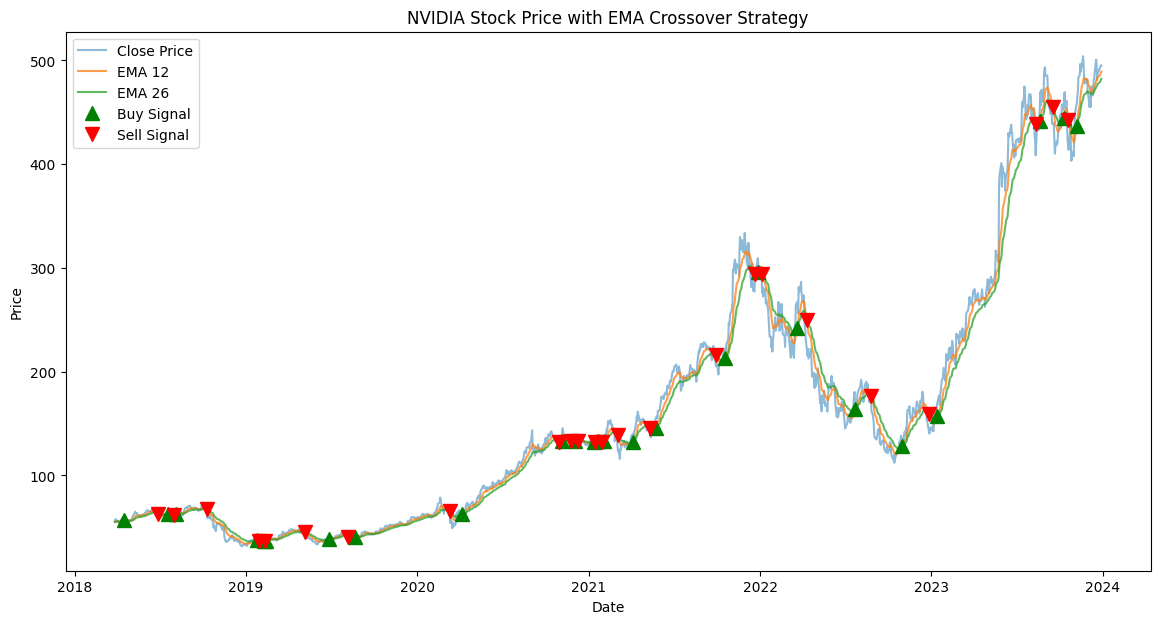

In [50]:
# Define the short and long window periods
short_window = 12
long_window = 26

# Calculate the EMAs
nvidia['EMA12'] = nvidia['Close'].ewm(span=short_window, adjust=False).mean()
nvidia['EMA26'] = nvidia['Close'].ewm(span=long_window, adjust=False).mean()

# Initialize signals
nvidia['Signal'] = 0

# Generate buy signals
nvidia.loc[nvidia.index[short_window:], 'Signal'] = np.where(nvidia['EMA12'][short_window:] > nvidia['EMA26'][short_window:], 1, 0)

# Generate trading orders
nvidia['Position'] = nvidia['Signal'].diff()

# Visualize signals
plt.figure(figsize=(14, 7))
plt.plot(nvidia['Close'], label='Close Price', alpha=0.5)
plt.plot(nvidia['EMA12'], label='EMA 12', alpha=0.75)
plt.plot(nvidia['EMA26'], label='EMA 26', alpha=0.75)
plt.plot(nvidia[nvidia['Position'] == 1].index, nvidia['EMA12'][nvidia['Position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(nvidia[nvidia['Position'] == -1].index, nvidia['EMA12'][nvidia['Position'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('NVIDIA Stock Price with EMA Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [51]:
# Prepare signals for ML strategy
nvidia['ml_signal'] = nvidia['Signal']

# Split the data into training and testing sets
train_size = int(len(nvidia) * 0.8)
train_df = nvidia[:train_size]
test_df = nvidia[train_size:]

# Features and target variable
X_train = train_df[['SMA10', 'SMA60', 'EMA10', 'EMA20', 'EMA50', 'Momentum', 'RSI']]
y_train = train_df['ml_signal']
X_test = test_df[['SMA10', 'SMA60', 'EMA10', 'EMA20', 'EMA50', 'Momentum', 'RSI']]
y_test = test_df['ml_signal']


In [52]:
# Train RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=25)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train XGBClassifier
xgb_model = XGBClassifier(n_estimators=25, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Add predictions to the test dataframe
test_df['rf_signal'] = rf_predictions
test_df['xgb_signal'] = xgb_predictions


C:\Users\Me\AppData\Local\Temp\ipykernel_8712\1295686822.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Me\AppData\Local\Temp\ipykernel_8712\1295686822.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



RandomForest Sharpe Ratio: 2.44
RandomForest Annualized Sharpe Ratio: 2.44
XGBoost Sharpe Ratio: 2.50
XGBoost Annualized Sharpe Ratio: 2.50


C:\Users\Me\AppData\Local\Temp\ipykernel_8712\3691927400.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Me\AppData\Local\Temp\ipykernel_8712\3691927400.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Me\AppData\Local\Temp\ipykernel_8712\3691927400.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

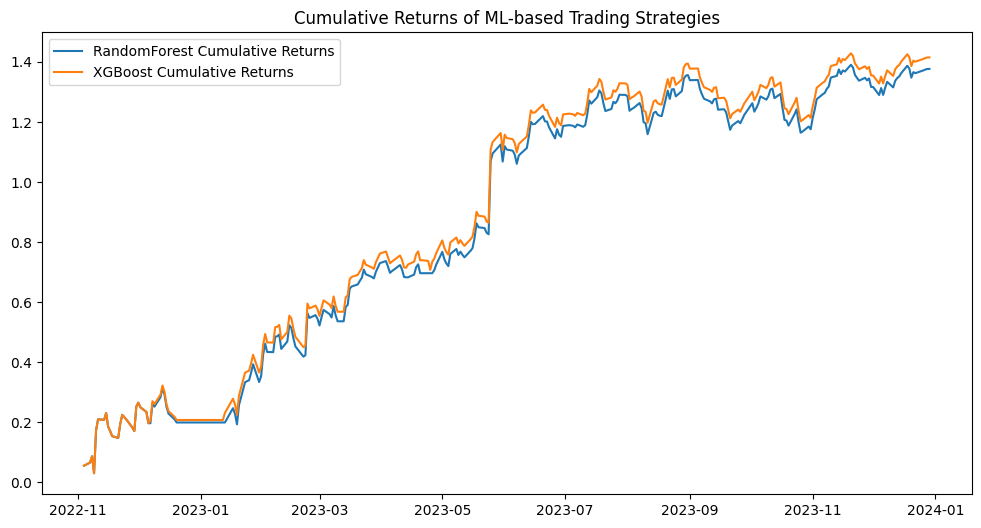

In [53]:
# Function to calculate returns and Sharpe ratio
def calculate_performance(df, signal_col):
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df[signal_col].shift(1) * df['returns']
    cumulative_returns = df['strategy_returns'].cumsum()

    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)

    annualized_return = df['strategy_returns'].mean() * 252
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
    annualized_sharpe_ratio = annualized_return / annualized_volatility

    return cumulative_returns, sharpe_ratio, annualized_sharpe_ratio

# Calculate performance for RandomForest strategy
rf_cumulative_returns, rf_sharpe_ratio, rf_annualized_sharpe_ratio = calculate_performance(test_df, 'rf_signal')

# Calculate performance for XGBoost strategy
xgb_cumulative_returns, xgb_sharpe_ratio, xgb_annualized_sharpe_ratio = calculate_performance(test_df, 'xgb_signal')

# Print performance metrics
print(f"RandomForest Sharpe Ratio: {rf_sharpe_ratio:.2f}")
print(f"RandomForest Annualized Sharpe Ratio: {rf_annualized_sharpe_ratio:.2f}")
print(f"XGBoost Sharpe Ratio: {xgb_sharpe_ratio:.2f}")
print(f"XGBoost Annualized Sharpe Ratio: {xgb_annualized_sharpe_ratio:.2f}")

# Plot cumulative returns for ML strategies
plt.figure(figsize=(12, 6))
plt.plot(rf_cumulative_returns, label='RandomForest Cumulative Returns')
plt.plot(xgb_cumulative_returns, label='XGBoost Cumulative Returns')
plt.title('Cumulative Returns of ML-based Trading Strategies')
plt.legend()
plt.show()
